In [1]:
# Import all the required packages

import numpy as np
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf

In [3]:
# Import Data.
# Data is divided into 3 sets. training, cross-validation and test
# Data is dumped into pickle dumps. 
# Data is of the format of a numpy array
# shape of the array is ('n', 3) where 'n' is the number of training/test samples. 
# Each row is a one-dim array of size 3. 
# data[:, 0] is the first feature
# data[:, 1] is the second feature
# data[:, 2] is the output value

# There are three classes in the data. The classes are specified using output values '0', '1' and '2'
# i.e. data[:, 2] belongs to the classes {0,1,2}


trainData = pickle.load(open("data/trainData.pickle", "rb"))
validationData = pickle.load(open("data/validationData.pickle", "rb"))
testData = pickle.load(open("data/testData.pickle", "rb"))


In [4]:
# Helper function to normalize the data
# Formula used for normalization (x - mean)/(std dev.)

def normalize_data(data, x0_mean, x1_mean, x0_std, x1_std, include_output = False):	
    temp_data = np.zeros((data.shape))
    temp_data[:, 0] = (data[:, 0] - x0_mean) / x0_std
    temp_data[:, 1] = (data[:, 1] - x1_mean) / x1_std
    if(include_output == True):
        temp_data[:, 2] = data[:, 2]
    return(temp_data)


In [8]:
# Compute the mean and standard deviation of training data so as to normalize it

train_x0_mean = np.mean(trainData[:, 0])
train_x1_mean = np.mean(trainData[:, 1])
train_x0_std = np.std(trainData[:, 0])
train_x1_std = np.std(trainData[:, 1])

In [9]:
nTrainData = normalize_data(trainData, train_x0_mean, train_x1_mean, train_x0_std, train_x1_std, True)
nValidationData = normalize_data(validationData, train_x0_mean, train_x1_mean, train_x0_std, train_x1_std, True)
nTestData = normalize_data(testData, train_x0_mean, train_x1_mean, train_x0_std, train_x1_std, True)

In [10]:
# Helper method to plot the data. 
# Since there are only two features, it is possible to plot data in a x,y plot


# d -- data
# num_classes -- no of classes in the data
# colors to use for each of the classes
def plotData(d, num_classes, colors):
    for i in range(num_classes):
        temp_data = d[d[:, 2] == i]
        plt.scatter(temp_data[:,0], temp_data[:,1], s = 2, color=colors[i])

    plt.show()

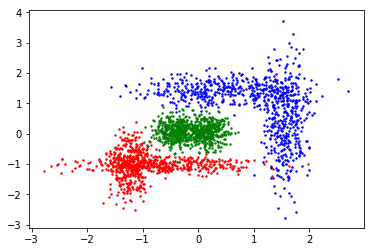

In [11]:
plotData(nTrainData, 3, ["red", "blue", "green"])

In [13]:
# Helper function to remap the data into 2 classes.
# This is required to execute the one-vs-all scheme of converting a binary classifier to a multi-class classifier

# Remap training data into binary classes
def remapData(data, positiveClass):
    tempData = np.zeros(data.shape)
    for i in range(data.shape[0]):
        tempData[i] = data[i]
        if(data[i, 2] != positiveClass):
            tempData[i, 2] = 0
        else:
            tempData[i, 2] = 1   
    return(tempData)     

In [14]:
# Build a logisitic regression classifier for class 0. 
# Mark class 0 as positive class and other two classes(class 1 and class 2 become negative class)

nTrainClass0Data = remapData(nTrainData, 0)
nValidationClass0Data = remapData(nValidationData, 0)

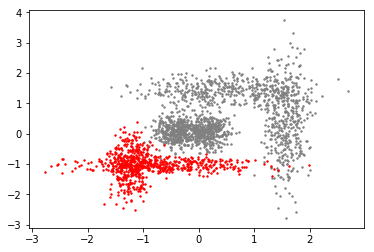

In [16]:
plotData(nTrainClass0Data, 2, ["grey", "red"])

In [17]:
# The first two columns are the input and the last column is the output

nTrainClass0_x = nTrainClass0Data[:, :2]
train_output = nTrainClass0Data[:, 2]

In [18]:
# Build the logistic classifier 


# Setup the Tensorflow nodes 

x = tf.placeholder(tf.float32, [None, 2])
W1 = tf.Variable(tf.truncated_normal([2,1], stddev = 0.1))
b1 = tf.Variable(tf.constant(0.1, shape = [1]))
y1 = tf.matmul(x, W1) + b1
y1_sig = tf.sigmoid(y1)
y_ = tf.placeholder(tf.float32, [None, ])


In [20]:
# Create the loss function and the gradient optimizer
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y_, logits = y1_sig[:,0]))

train_step = tf.train.AdagradOptimizer(2.0).minimize(loss)

In [21]:
# Run the training

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
loss_arr = []
for _ in range(10000):
    sess.run(train_step, feed_dict={x: nTrainClass0_x, y_: train_output})
    W1_val, b1_val, y1_sig_val, loss_val = sess.run([W1, b1, y1_sig, loss],
     feed_dict = {x: nTrainClass0_x, y_: train_output})
    loss_arr.append(loss_val)



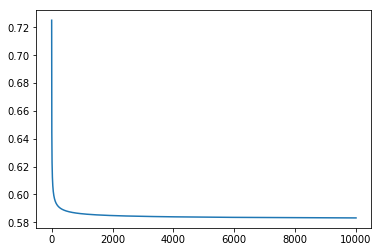

In [22]:
# Plot the decay in loss, to ensure that the loss has stabilized

plt.plot(loss_arr)
plt.show()

In [23]:
# Test Validation Data to measure accuracy

# Create input data for validation
nValidation_x = nValidationClass0Data[:, :2]

# Feed the input validation data to the trained model
[validation_y1_sig] = sess.run([y1_sig], feed_dict={x: nValidation_x})

# Obtain the predictions. 
y_pred = np.ndarray.flatten(validation_y1_sig >=0.5)

# Store the results for calculating overall accruacy later 
all_results = validation_y1_sig.copy()


validation_output = nValidationClass0Data[:, 2]

# If output of model and actual output is same then the model has predicted correctly
y_act = validation_output == 1
result = (~y_pred & ~y_act) | (y_pred & y_act)

print("Accuracy = %s"%(sum(result)*100/len(validation_output))) 

Accuracy = 97.0


In [24]:
# Draw the decision boundaries
all_points = np.empty([0,2])
for x_i in range(-70, 220):
    for y_i in range (-60, 200):
        all_points = np.append(all_points, [[x_i, y_i]], axis = 0)

n_all_points = normalize_data(all_points, train_x0_mean, train_x1_mean, train_x0_std, train_x1_std)        

In [27]:
# Run model on all points
[all_y1_sig] = sess.run([y1_sig], feed_dict={x: n_all_points})
y_sig_class0 = all_y1_sig
y_pred_class0 = np.ndarray.flatten(all_y1_sig >=0.5)
n_result = y_pred_class0*1
n_result_reshaped = n_result.reshape(75400, 1)
plot_points = np.append(n_all_points, n_result_reshaped, axis=1)

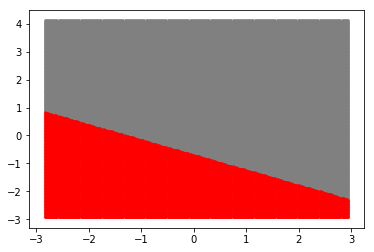

In [28]:
# Plot the results
plotData(plot_points, 2, ["grey", "red"])

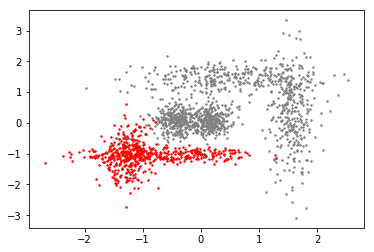

In [29]:
# Plot validation data for comparison
plotData(nValidationClass0Data, 2, ["grey", "red"])

In [30]:
# Perform all the above steps again for Class 1
nTrainClass1Data = remapData(nTrainData, 1)
nValidationClass1Data = remapData(nValidationData, 1)

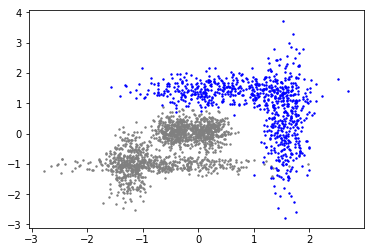

In [32]:
# Plot the training data
plotData(nTrainClass1Data, 2, ["grey", "blue"])

In [33]:
nTrainClass1_x = nTrainClass1Data[:, :2]
train_output = nTrainClass1Data[:, 2]

In [34]:
x = tf.placeholder(tf.float32, [None, 2])

W1 = tf.Variable(tf.truncated_normal([2,1], stddev = 0.1))
b1 = tf.Variable(tf.constant(0.1, shape = [1]))
y1 = tf.matmul(x, W1) + b1
y1_sig = tf.sigmoid(y1)
y_ = tf.placeholder(tf.float32, [None, ])

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y_, logits = y1_sig[:,0]))
train_step = tf.train.AdagradOptimizer(2.0).minimize(loss)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
loss_arr = []
for _ in range(10000):
    sess.run(train_step, feed_dict={x: nTrainClass1_x, y_: train_output})
    W1_val, b1_val, y1_sig_val, loss_val = sess.run([W1, b1, y1_sig, loss],
     feed_dict = {x: nTrainClass1_x, y_: train_output})
    loss_arr.append(loss_val)



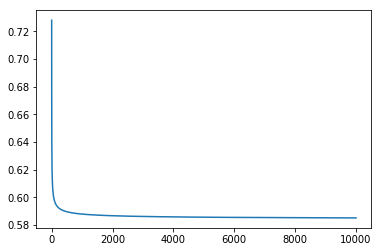

In [35]:
plt.plot(loss_arr)
plt.show()

In [36]:
nValidation_x = nValidationClass1Data[:, :2]
[validation_y1_sig] = sess.run([y1_sig], feed_dict={x: nValidation_x})
all_results = np.append(all_results, validation_y1_sig, axis=1)

validation_output = nValidationClass1Data[:, 2]
y_pred = np.ndarray.flatten(validation_y1_sig >=0.5)
y_act = validation_output == 1
result = (~y_pred & ~y_act) | (y_pred & y_act)
print("Accuracy = %s"%(sum(result)*100/len(validation_output))) 

Accuracy = 94.7222222222


In [37]:
[all_y1_sig] = sess.run([y1_sig], feed_dict={x: n_all_points})
y_sig_class1 = all_y1_sig
y_pred_class1 = np.ndarray.flatten(all_y1_sig >=0.5)
n_result = y_pred_class1*1
a = n_result.reshape(75400, 1)
plot_points = np.append(n_all_points, a, axis=1)

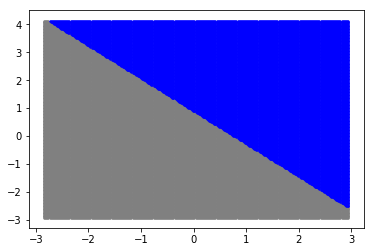

In [38]:
plotData(plot_points, 2, ["grey", "blue"])

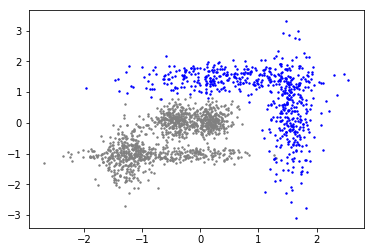

In [39]:
# Plot validation data for comparison
plotData(nValidationClass1Data, 2, ["grey", "blue"])

In [40]:
nTrainClass2Data = remapData(nTrainData, 2)
nValidationClass2Data = remapData(nValidationData, 2)

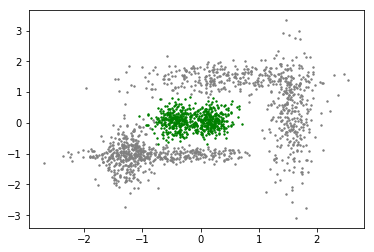

In [49]:
plotData(nValidationClass2Data, 2, ["grey", "green"])

In [50]:
nTrainClass2_x = nTrainClass2Data[:, :2]
train_output = nTrainClass2Data[:, 2]

In [51]:
x = tf.placeholder(tf.float32, [None, 2])

W1 = tf.Variable(tf.truncated_normal([2,1], stddev = 0.1))
b1 = tf.Variable(tf.constant(0.1, shape = [1]))
y1 = tf.matmul(x, W1) + b1
y1_sig = tf.sigmoid(y1)
y_ = tf.placeholder(tf.float32, [None, ])

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y_, logits = y1_sig[:,0]))
train_step = tf.train.AdagradOptimizer(2.0).minimize(loss)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()
loss_arr = []
for _ in range(10000):
    sess.run(train_step, feed_dict={x: nTrainClass2_x, y_: train_output})
    W1_val, b1_val, y1_sig_val, loss_val = sess.run([W1, b1, y1_sig, loss],
     feed_dict = {x: nTrainClass2_x, y_: train_output})
    loss_arr.append(loss_val)

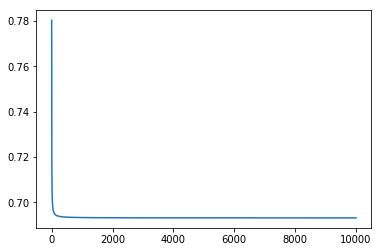

In [52]:
plt.plot(loss_arr)
plt.show()

In [53]:
y_pred = np.ndarray.flatten(y1_sig_val >=0.5)
y_act = train_output == 1
result = (~y_pred & ~y_act) | (y_pred & y_act)
nValidation_x = nValidationClass2Data[:, :2]
[validation_y1_sig] = sess.run([y1_sig], feed_dict={x: nValidation_x})

all_results = np.append(all_results, validation_y1_sig, axis=1)


validation_output = nValidationClass1Data[:, 2]
y_pred = np.ndarray.flatten(validation_y1_sig >=0.5)
y_act = validation_output == 1
result = (~y_pred & ~y_act) | (y_pred & y_act)
print("Accuracy = %s"%(sum(result)*100/len(validation_output))) 

Accuracy = 66.8333333333


In [54]:
[all_y1_sig] = sess.run([y1_sig], feed_dict={x: n_all_points})
y_sig_class2 = all_y1_sig
y_pred_class2 = np.ndarray.flatten(all_y1_sig >=0.5)
n_result = y_pred_class2*1
a = n_result.reshape(75400, 1)
plot_points = np.append(n_all_points, a, axis=1)

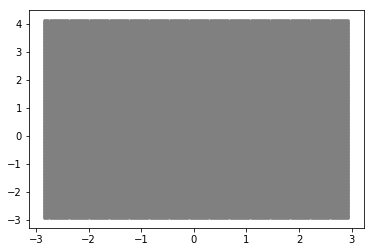

In [55]:
plotData(plot_points, 2, ["grey", "green"])

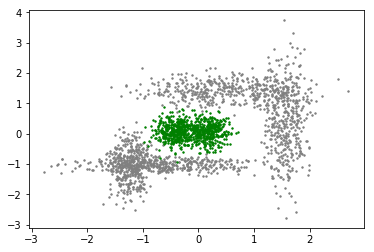

In [57]:
plotData(nTrainClass2Data, 2, ["grey", "green"])

In [58]:
# Now combine all the models and make predictions for all the three classes
# Each model will give three probabilities. One for each class. Assign class which has the maximum probability
pred_classes = np.argmax(all_results, axis=1)

In [60]:
validation_output_int = validation_output.astype(int)

In [61]:
print("Overall Accuracy for validation data = %s"%(sum(pred_classes == validation_output_int) *100/len(validation_output)))

Overall Accuracy for validation data = 73.2222222222


In [63]:
y_sig_class01 = np.append(y_sig_class0, y_sig_class1, axis=1)
y_sig_class012 = np.append(y_sig_class01, y_sig_class2, axis=1)

In [64]:
all_pred_classes = np.argmax(y_sig_class012, axis=1)

In [65]:
all_pred_classes_reshaped = all_pred_classes.reshape(75400, 1)

In [67]:
plot_points = np.append(n_all_points, all_pred_classes_reshaped, axis=1)

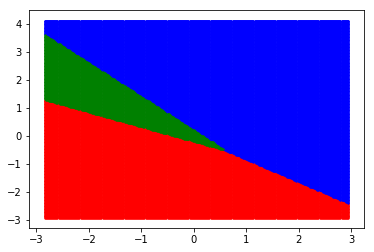

In [68]:
plotData(plot_points, 3, ["red", "blue", "green"])

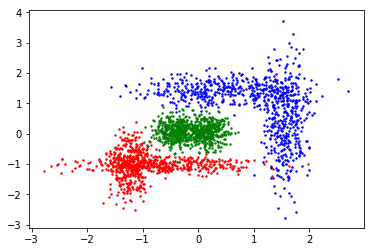

In [70]:
plotData(nTrainData, 3, ["red", "blue", "green"])